# 오버워치 2 점수판 분석 AI

In [1]:
import os
import pandas as pd

players = 10


def prepare_scoreboards(defeat_, draw_, victory_):
    scoreboards_ = pd.concat([defeat_, draw_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = os.path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
draw = pd.read_csv(datapath + 'draw.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, draw, victory)
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = scoreboards['D'].max()
scoreboards

E   A   D    DMG      H    MIT    GAME
0   0   7   3   6   5933   1068   6199  DEFEAT
    1   7   0  10   3601    747      0  DEFEAT
    2   9   1   6   4352      0      0  DEFEAT
    3   7   7   2   2332   6325      0  DEFEAT
    4   6   4   2   3410   5979    606  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
252 5  34   9   7  15597   1508  15282  DEFEAT
    6  28   1  12  14064   1339    238  DEFEAT
    7  29   1  13  12145      0     48  DEFEAT
    8  11  26   9   2798  16190   1352  DEFEAT
    9   4  24   8    743  20730    176  DEFEAT

[2530 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2530 entries, (0, 0) to (252, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       2530 non-null   int64 
 1   A       2530 non-null   int64 
 2   D       2530 non-null   int64 
 3   DMG     2530 non-null   int64 
 4   H       2530 non-null   int64 
 5   MIT     2530 non-null   int64 
 6   GAME    2530 non-null   object
dtypes: int64(6), object(1)
memory usage: 156.3+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000
mean,13.945850,7.436759,6.588933,6276.227273,3891.819368,2322.424901
std,10.408151,8.782112,4.124807,4690.081391,5200.591907,4684.890883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2675.750000,0.000000,0.000000
50%,12.000000,4.000000,6.000000,5344.500000,803.000000,243.000000
75%,20.000000,12.000000,9.000000,9292.500000,7427.250000,1699.750000
max,56.000000,48.000000,21.000000,29354.000000,27756.000000,41092.000000


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = os.path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
tank = scoreboards[::players]
damage = pd.concat([scoreboards[1::players], scoreboards[2::players]])
support = pd.concat([scoreboards[3::players], scoreboards[4::players]])

그림 저장:tank_hist


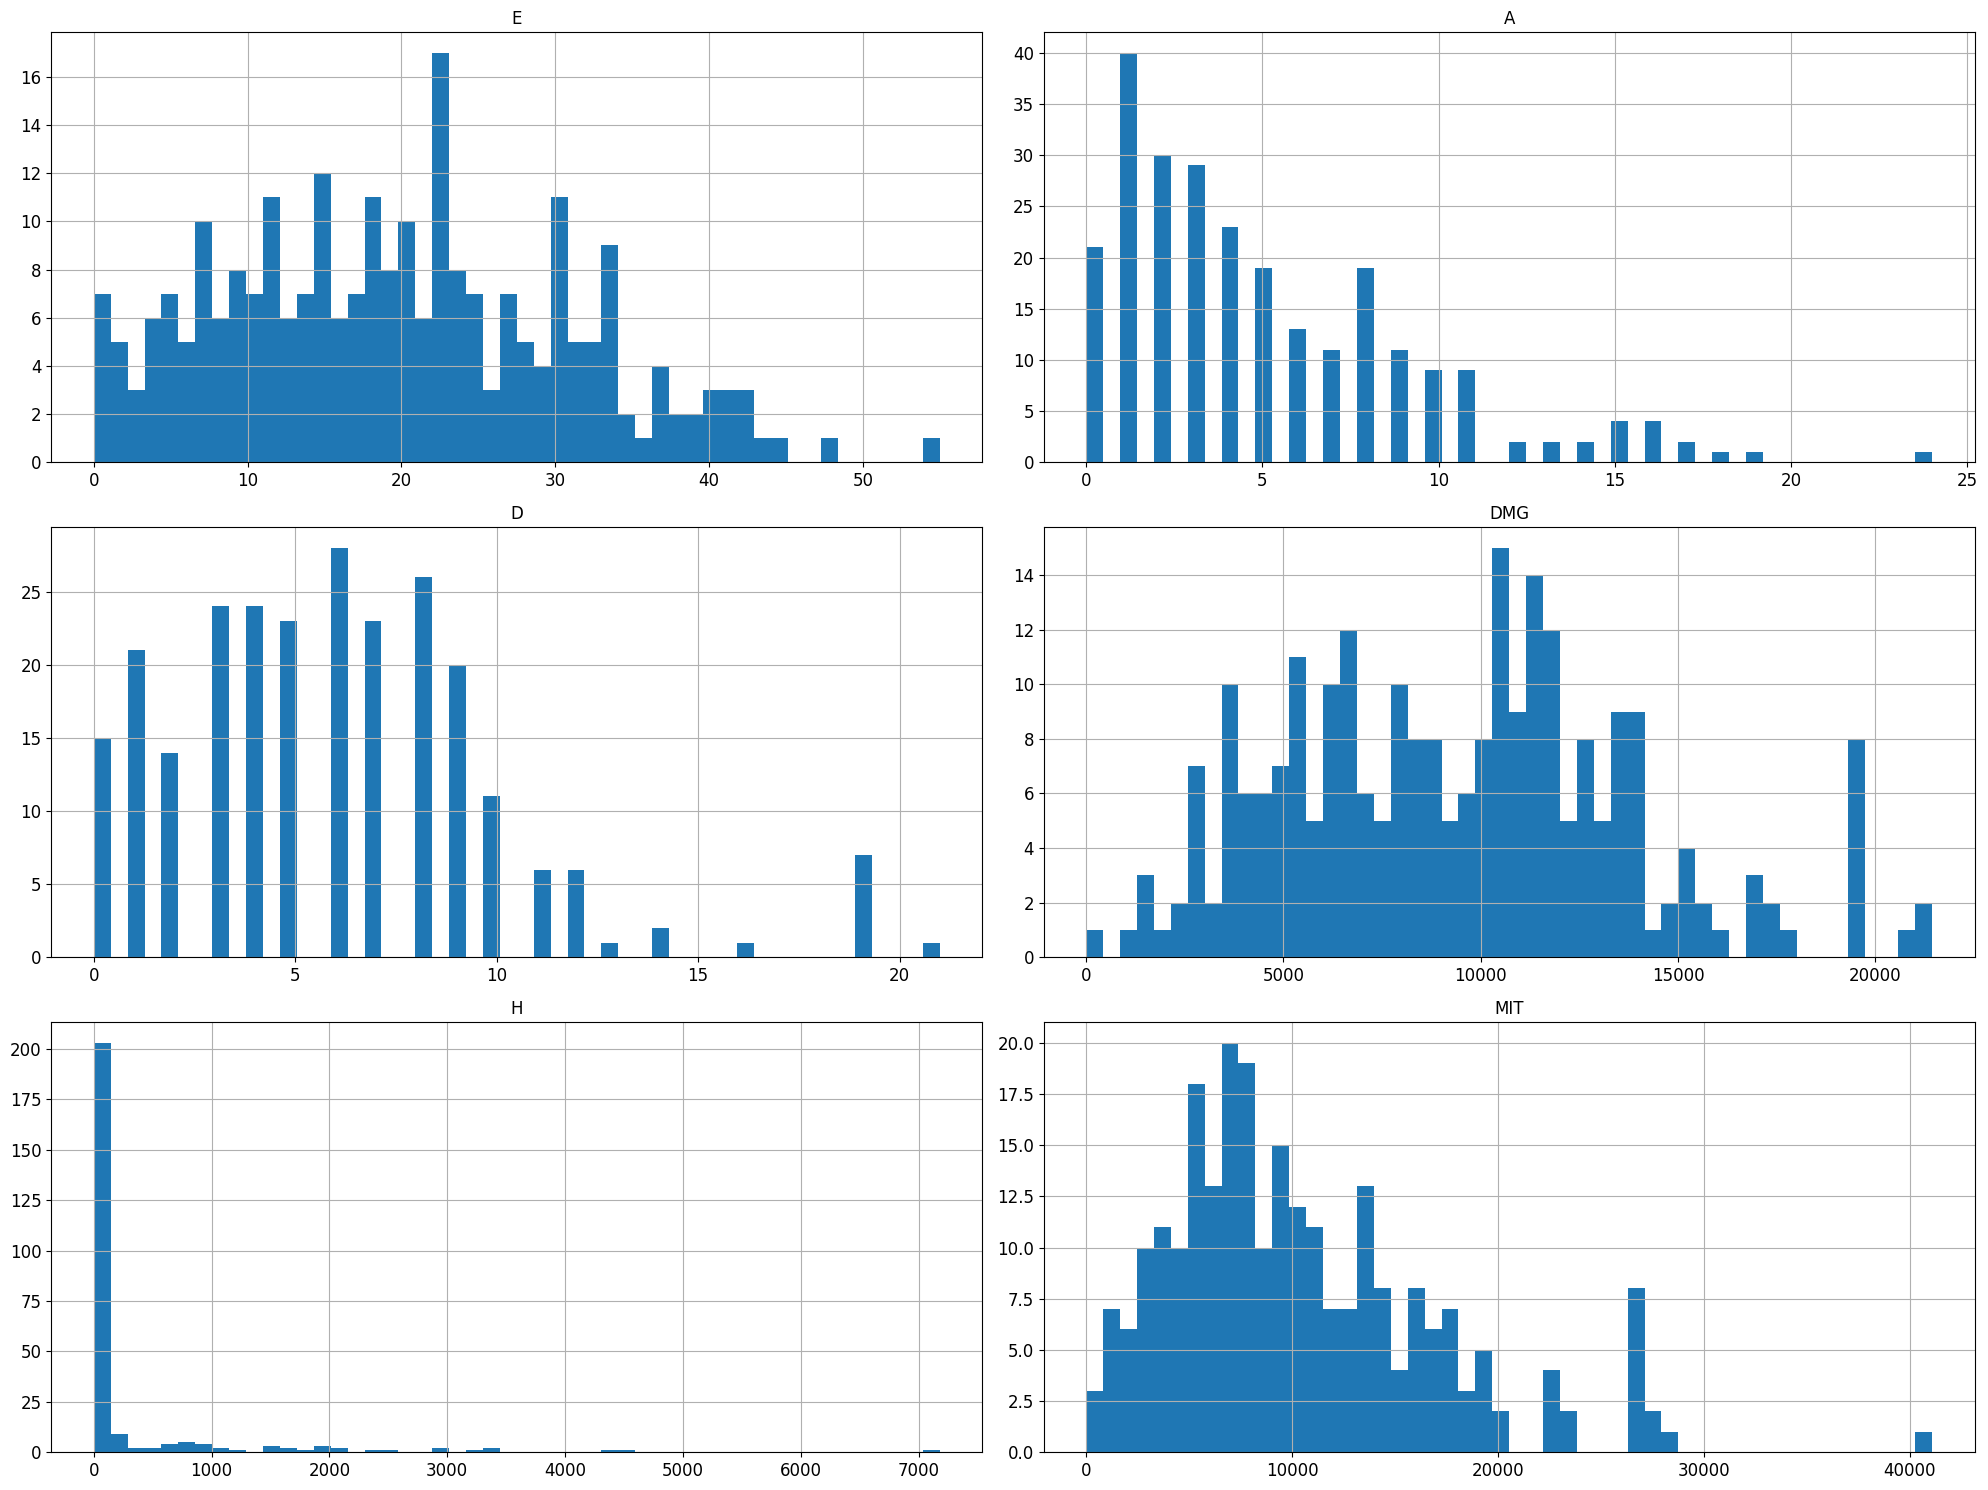

In [6]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


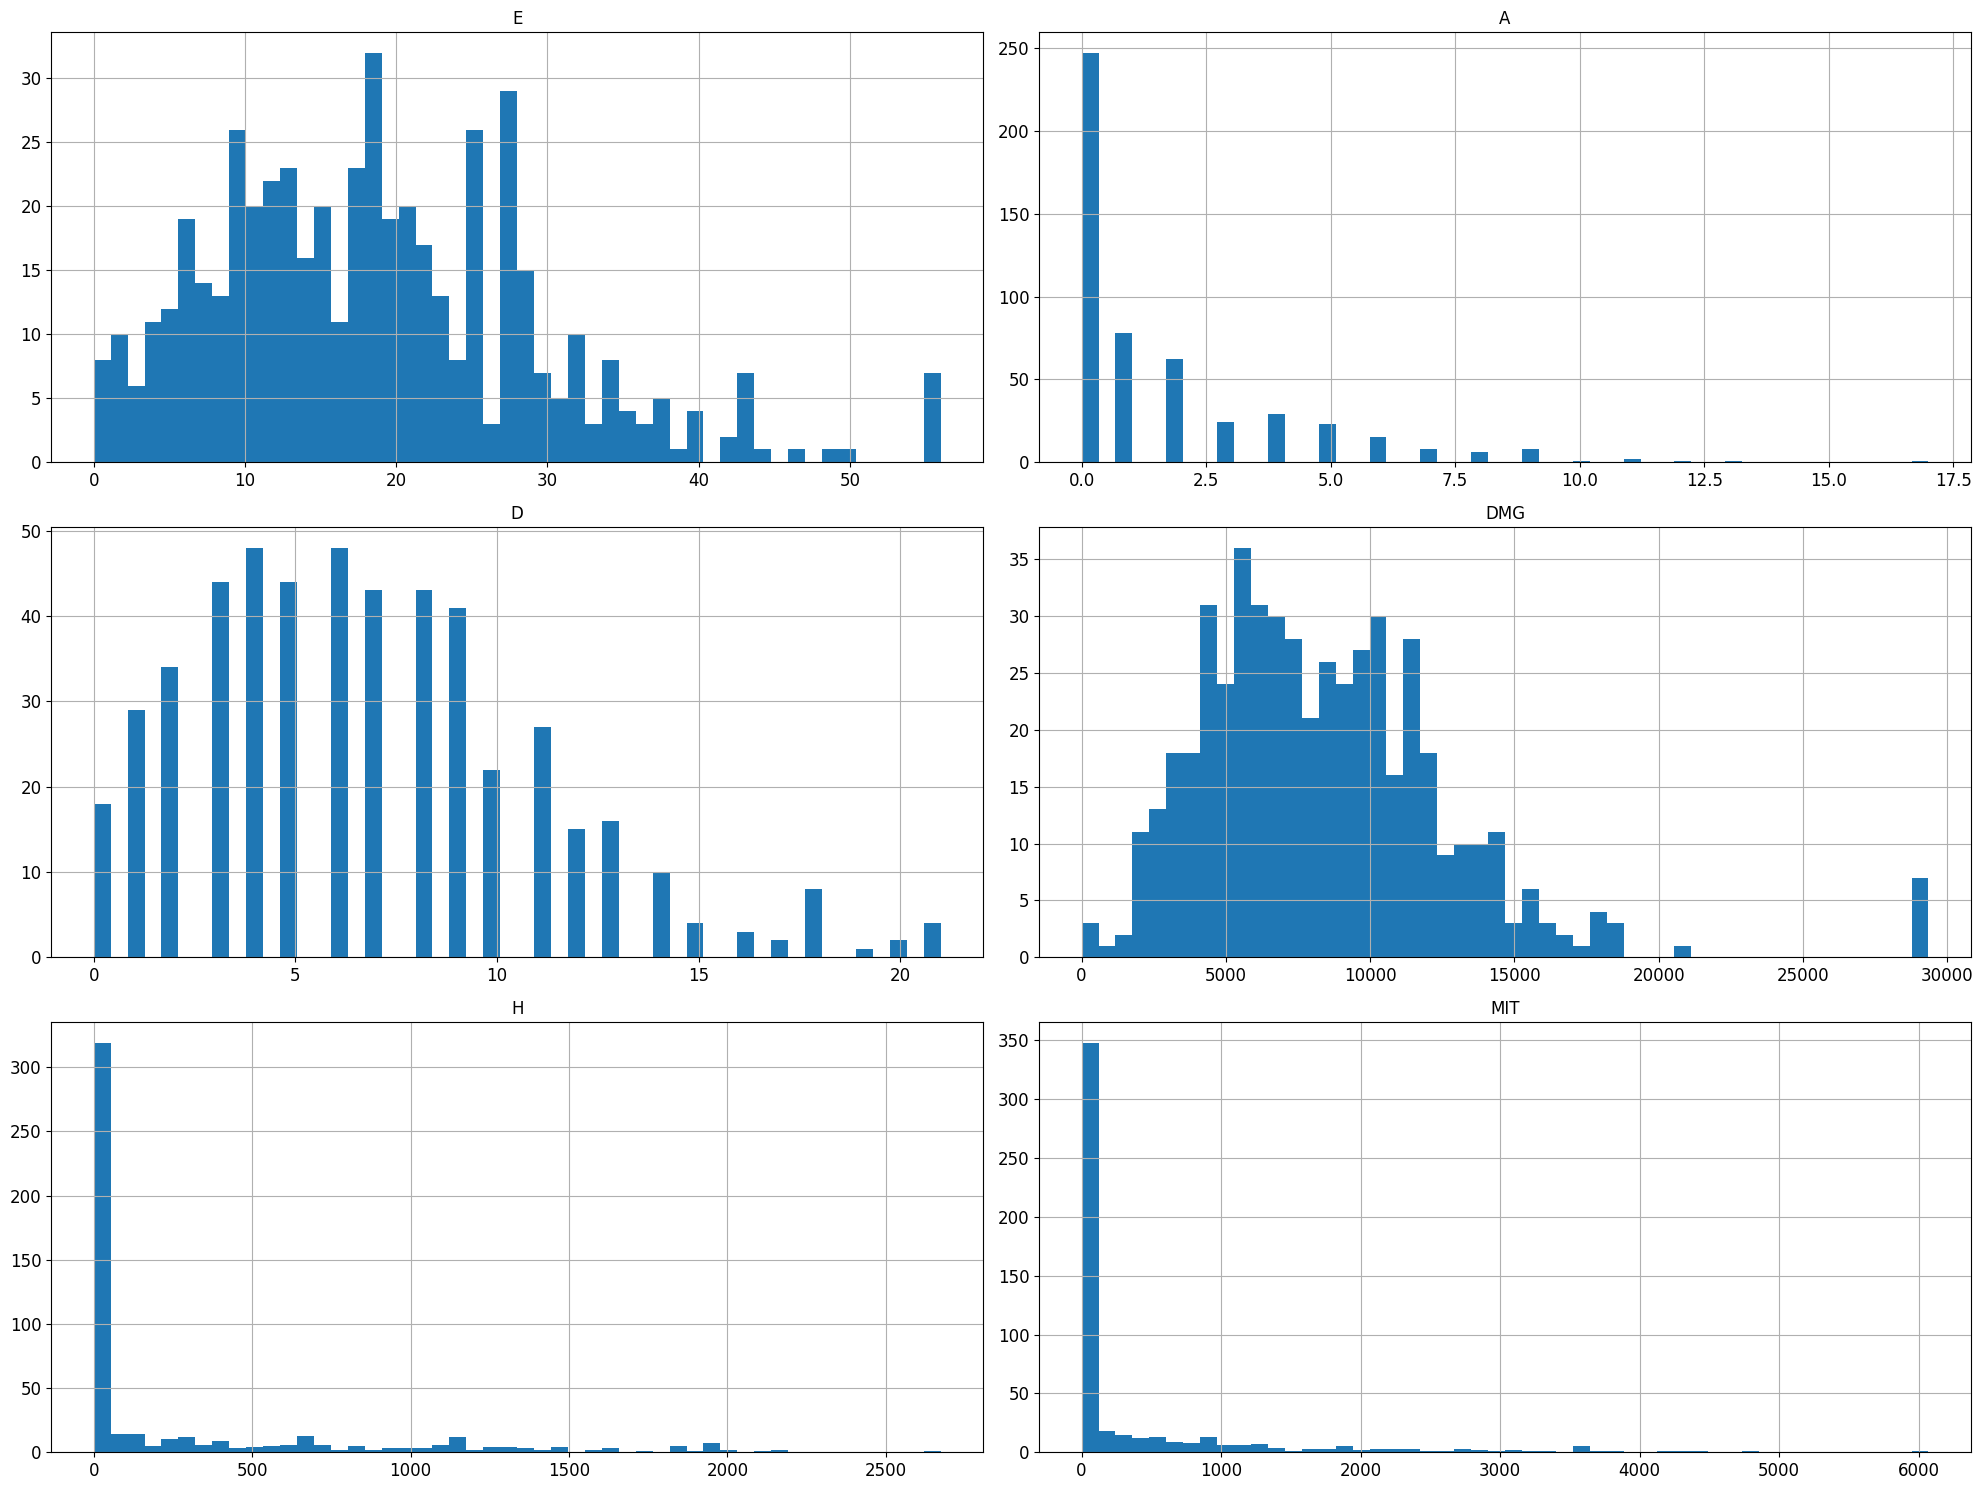

In [7]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


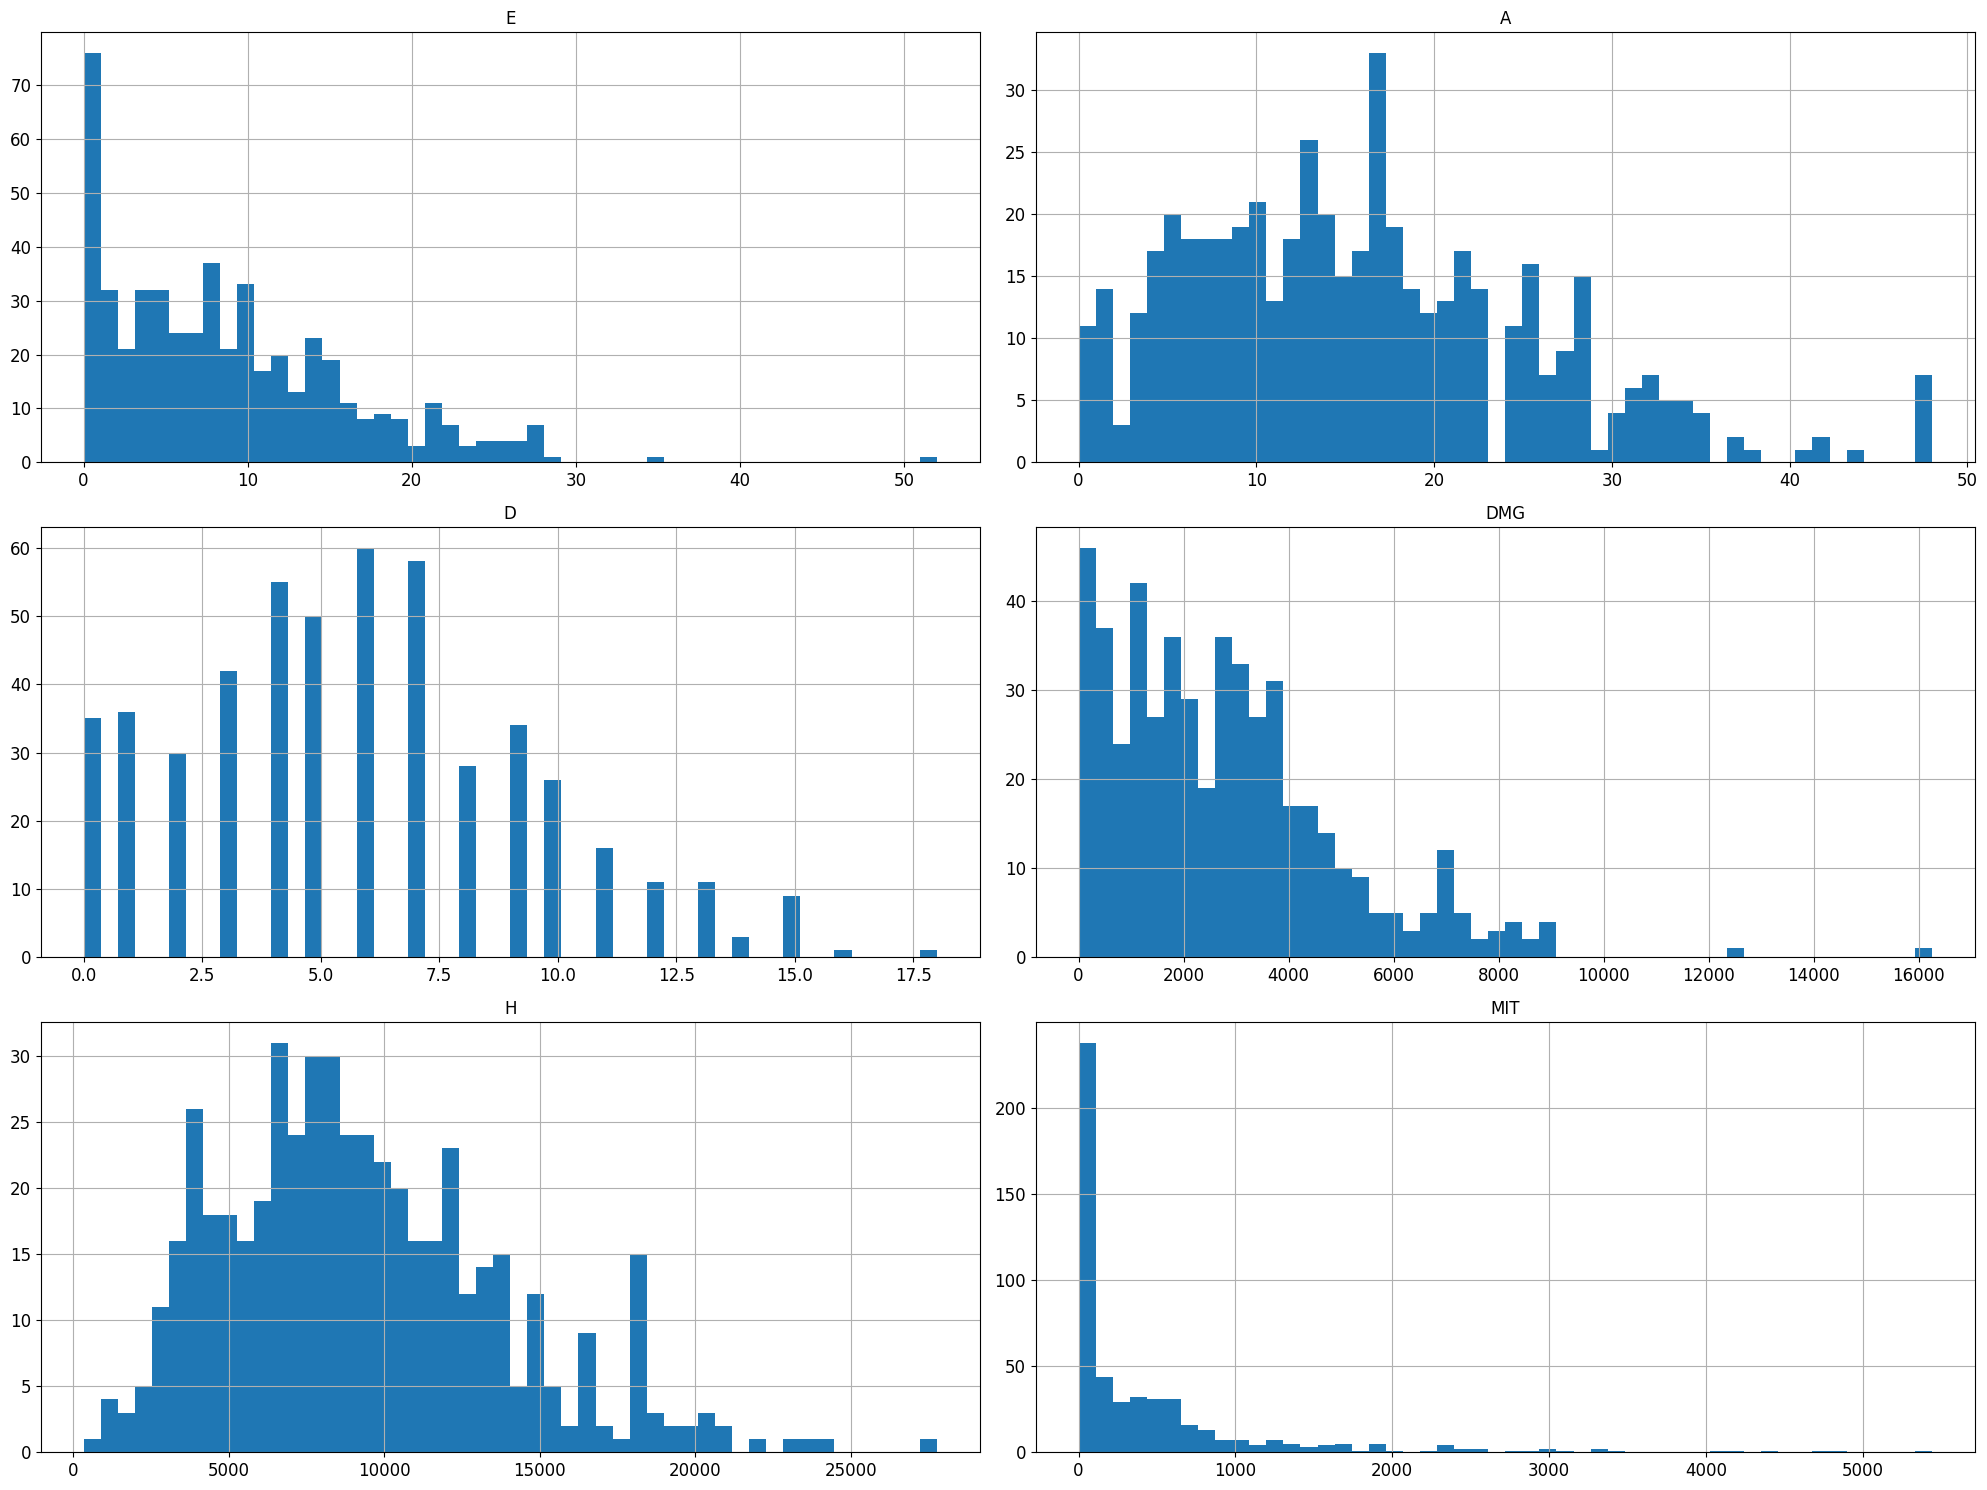

In [8]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [9]:
from sklearn.utils import shuffle

index = scoreboards.index
train_set = scoreboards.loc[shuffle(range(len(index) // players))]
train_set

E   A   D    DMG      H    MIT    GAME
66  0  20   4   8   7543      0   9632  DEFEAT
    1  11   0   6   7852      0    469  DEFEAT
    2  13   1   9   7668    540      0  DEFEAT
    3   6   9  10   3105   5211     60  DEFEAT
    4   5  12   6   1659   8874    268  DEFEAT
...    ..  ..  ..    ...    ...    ...     ...
211 5  21   7  12   7760   3346  13942  DEFEAT
    6  22   3   5  10328    296   3678  DEFEAT
    7  20   0   6  11867      0      0  DEFEAT
    8   2  19  10    897  12895      0  DEFEAT
    9   9  14   7   2942  15666    464  DEFEAT

[2530 rows x 7 columns]

In [10]:
scoreboards = train_set.drop('GAME', axis=1)
scoreboards_labels = train_set['GAME'].copy()

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(scoreboards)
scoreboards_tr = pd.DataFrame(X, index, scoreboards.columns)
scoreboards_tr

E         A         D       DMG         H       MIT
0   0  0.357143  0.083333  0.380952  0.256967  0.000000  0.234401
    1  0.196429  0.000000  0.285714  0.267493  0.000000  0.011413
    2  0.232143  0.020833  0.428571  0.261225  0.019455  0.000000
    3  0.107143  0.187500  0.476190  0.105778  0.187743  0.001460
    4  0.089286  0.250000  0.285714  0.056517  0.319715  0.006522
...         ...       ...       ...       ...       ...       ...
252 5  0.375000  0.145833  0.571429  0.264359  0.120551  0.339287
    6  0.392857  0.062500  0.238095  0.351843  0.010664  0.089506
    7  0.357143  0.000000  0.285714  0.404272  0.000000  0.000000
    8  0.035714  0.395833  0.476190  0.030558  0.464584  0.000000
    9  0.160714  0.291667  0.333333  0.100225  0.564419  0.011292

[2530 rows x 6 columns]

In [12]:
features = X.shape[-1]
X = X.reshape(-1, players * features)
X

array([[0.35714286, 0.08333333, 0.38095238, ..., 0.01693125, 0.3659389 ,
        0.        ],
       [0.33928571, 0.16666667, 0.23809524, ..., 0.15759351, 0.38780804,
        0.        ],
       [0.53571429, 0.10416667, 0.9047619 , ..., 0.11640662, 0.76080847,
        0.        ],
       ...,
       [0.25      , 0.04166667, 0.28571429, ..., 0.02950194, 0.31852572,
        0.00391804],
       [0.66071429, 0.1875    , 0.14285714, ..., 0.11627035, 0.28707307,
        0.03000584],
       [0.48214286, 0.1875    , 0.42857143, ..., 0.10022484, 0.5644185 ,
        0.01129174]])

In [13]:
scoreboards_tr[:10]

E         A         D       DMG         H       MIT
0 0  0.357143  0.083333  0.380952  0.256967  0.000000  0.234401
  1  0.196429  0.000000  0.285714  0.267493  0.000000  0.011413
  2  0.232143  0.020833  0.428571  0.261225  0.019455  0.000000
  3  0.107143  0.187500  0.476190  0.105778  0.187743  0.001460
  4  0.089286  0.250000  0.285714  0.056517  0.319715  0.006522
  5  0.357143  0.020833  0.142857  0.286469  0.000000  0.132702
  6  0.410714  0.000000  0.238095  0.459937  0.030876  0.000049
  7  0.321429  0.000000  0.285714  0.310997  0.000000  0.011535
  8  0.035714  0.291667  0.333333  0.025959  0.267906  0.008396
  9  0.071429  0.333333  0.238095  0.016931  0.365939  0.000000

In [14]:
X.shape

(253, 60)

In [15]:
y = scoreboards_labels[::players]
y

66   0     DEFEAT
249  0    VICTORY
128  0       DRAW
228  0    VICTORY
214  0    VICTORY
           ...   
224  0    VICTORY
240  0    VICTORY
59   0     DEFEAT
196  0    VICTORY
211  0    VICTORY
Name: GAME, Length: 253, dtype: object

In [16]:
y.shape

(253,)

In [17]:
from sklearn import ensemble, linear_model, neighbors, neural_network, svm, tree
from sklearn.model_selection import cross_val_score
from operator import itemgetter

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=300, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(2., n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=300),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(nu=.09),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=itemgetter(1), reverse=True)
scores

[(SVC(), 0.9129411764705881),
 (LogisticRegressionCV(max_iter=300, n_jobs=-1), 0.9049411764705881),
 (LogisticRegression(n_jobs=-1), 0.9048627450980392),
 (ExtraTreesClassifier(n_jobs=-1), 0.8970980392156862),
 (RandomForestClassifier(n_jobs=-1), 0.8970980392156862),
 (NearestCentroid(), 0.8970980392156862),
 (RidgeClassifier(), 0.8969411764705881),
 (RidgeClassifierCV(), 0.8969411764705881),
 (LinearSVC(dual='auto'), 0.8930196078431372),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.8891764705882353),
 (KNeighborsClassifier(n_jobs=-1), 0.8890980392156862),
 (SGDClassifier(n_jobs=-1), 0.8813333333333333),
 (Perceptron(n_jobs=-1), 0.8810196078431373),
 (GradientBoostingClassifier(), 0.8775686274509804),
 (HistGradientBoostingClassifier(), 0.8772549019607843),
 (NuSVC(nu=0.09), 0.8733333333333333),
 (MLPClassifier(max_iter=300), 0.8695686274509804),
 (BaggingClassifier(n_jobs=-1), 0.8577254901960784),
 (DecisionTreeClassifier(), 0.7903529411764706),
 (ExtraTreeClassifier(), 0.7625098039215

In [18]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        print(estimator)
        importances = estimator.feature_importances_.reshape(-1, features)
        importances_tanks = importances[[0, 5]].sum(0)
        importances_damages = importances[[1, 2, 6, 7]].sum(0)
        importances_supports = importances[[3, 4, 8, 9]].sum(0)
        importance_tanks = importances_tanks.sum()
        importance_damages = importances_damages.sum()
        importance_supports = importances_supports.sum()

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('\n**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**돌격 1인 특성 중요도**')
        for importance, title in sorted(zip(importances_tanks, titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**공격 1인 특성 중요도**')
        for importance, title in sorted(zip(importances_damages / 2, titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**지원 1인 특성 중요도**')
        for importance, title in sorted(zip(importances_supports / 2, titles), reverse=True):
            print(f'{title}: {importance * 100:.0f}%')

        print('\n**역할 중요도**')
        for importance, title in sorted(
                zip((importance_tanks, importance_damages / 2, importance_supports / 2), ('돌격 1인', '공격 1인', '지원 1인')),
                reverse=True
        ):
            print(f'{title}: {importance * 100:.0f}%')

        break

ExtraTreesClassifier(n_jobs=-1)

**특성 중요도**
처치: 28%
죽음: 26%
도움: 21%
피해: 10%
치유: 8%
경감: 6%

**돌격 1인 특성 중요도**
처치: 10%
죽음: 9%
도움: 5%
피해: 2%
경감: 2%
치유: 1%

**공격 1인 특성 중요도**
처치: 6%
죽음: 4%
피해: 2%
치유: 2%
도움: 2%
경감: 1%

**지원 1인 특성 중요도**
도움: 6%
죽음: 5%
처치: 3%
치유: 2%
피해: 1%
경감: 1%

**역할 중요도**
돌격 1인: 29%
지원 1인: 19%
공격 1인: 17%


In [59]:
index_1 = 6
index_2 = index_1 * players
scoreboard = scoreboards[index_2:index_2 + players]
scoreboard_index = scoreboard.index[0][0] + 1
defeats = len(defeat) // players
defeats_draws = defeats + len(draw) // players
if scoreboard_index <= defeats:
    print(f'\nDEFEAT: {scoreboard_index}')
elif scoreboard_index <= defeats_draws:
    print(f'\nDRAW: {scoreboard_index - defeats}')
else:
    print(f'\nVICTORY: {scoreboard_index - defeats_draws}')
scoreboard


VICTORY: 5


E   A   D    DMG      H   MIT
133 0  28   7   1  10429   2109  2839
    1  34   1   9  10209      0   324
    2  22   5   7   7865      0    50
    3  15  19   0   3362   7017     0
    4  13  18   3   3412   6986    14
    5   5   1  11   5346    851  7212
    6   9   6   8   5901    145   110
    7  14   0  12  10562    164     0
    8   2  11   8   2048  10177     0
    9   4   5  13   2515   6082   403

In [60]:
scoreboard = X[index_1].reshape(players, features).copy()
scoreboard[:, 2] = 1 - scoreboard[:, 2]
scoreboard[[0, 5]] *= importances_tanks / 2
scoreboard[[1, 2, 6, 7]] *= importances_damages / 4
scoreboard[[3, 4, 8, 9]] *= importances_supports / 4
scores = scoreboard.sum(1)
contributions = scores / scoreboard.sum()
print('**기여도**')
print(f'TEAM 1:', end='')
for contribution in contributions[:5]:
    print(f' {contribution:.2%}', end='')
print(f'\nTEAM 2:', end='')
for contribution in contributions[5:]:
    print(f' {contribution:.2%}', end='')

scores /= ([scores[[0, 5]].sum()] + [scores[[1, 2, 6, 7]].sum()] * 2 + [scores[[3, 4, 8, 9]].sum()] * 2) * 2
scores *= ((2,) + (4,) * 4) * 2
print('\n\n**기여몫**')
print(f'TEAM 1:', end='')
for share in scores[:5]:
    print(f' {share:.2f}', end='')
print(f'\nTEAM 2:', end='')
for share in scores[5:]:
    print(f' {share:.2f}', end='')

**기여도**
TEAM 1: 22.43% 10.34% 8.85% 12.93% 11.55%
TEAM 2: 8.79% 6.25% 6.19% 7.85% 4.81%

**기여몫**
TEAM 1: 1.44 1.31 1.12 1.39 1.24
TEAM 2: 0.56 0.79 0.78 0.85 0.52

In [ ]:
# classifiers = []
# for i in range(3, len(scores)):
#     classifiers.append((i, cross_val_score(ensemble.VotingClassifier([(str(j), scores[j][0]) for j in range(i)], n_jobs=-1), X, y, n_jobs=-1).mean()))
# classifiers.sort(key=itemgetter(1), reverse=True)
# classifiers

In [ ]:
cross_val_score(ensemble.StackingClassifier([(str(i), scores[i][0]) for i in range(7)], scores[0][0], n_jobs=-1), X, y, n_jobs=-1).mean()

In [ ]:
scores

In [ ]:
model = scores[0][1]
for i, (y_true, y_pred) in enumerate(zip(y_test.values, model.predict(X_test))):
    if y_true != y_pred:
        i = y_test.index[i][0]
        defeats = len(defeat) // players
        sum_ = defeats + len(draw) // players
        next_ = i + 1
        if i < defeats:
            print(f'{y_true} ({next_}) -> {y_pred} ({i})')
        elif i < sum_:
            print(f'{y_true} ({next_ - defeats}) -> {y_pred} ({i})')
        else:
            print(f'{y_true} ({next_ - sum_}) -> {y_pred} ({i})')
        print(test.loc[i], end='\n\n')